In [74]:
import os.path as osp
import time
import pickle
import sys
import os
import numpy as np
code_path = os.path.abspath('../code')
sys.path.append(code_path)
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from tqdm import tqdm

from model import DeepVCF_Model
from data_utils import DeepVCF_Knowledge, DeepVCF_Data
from utils import set_seeds

## load trained model
User can trained their own model using our code (see train_deepvcf.py) \

In [120]:
# load model after training(train_deepvcf.py), we provide 5 models trained on ECO dataset before 2023 using seed 44,52,62,72,82
model_dir = '/home/shengkun/lab_github/DeepVCF/trained_model/ECO/'
model_name = 'DeepVCF_72'
device = 'cuda:2'

In [121]:
# load trained DeepVCF
entity2idx = np.load(model_dir+'index_dict/entity2idx.npy', allow_pickle=True).item()
relation2idx = np.load(model_dir+'index_dict/relation2idx.npy', allow_pickle=True).item()
model = DeepVCF_Model.load_model(model_dir + model_name + '.pt', device=device)

[OK] Model loaded ← /home/shengkun/lab_github/DeepVCF/trained_model/ECO/DeepVCF_72.pt


/home/shengkun/lab_github/DeepVCF/code/model.py:623: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


## Reproduce results
results are based on our reproduced model.


In [122]:
train_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/train_data/train.txt'
test_path = '/home/shengkun/lab_github/DeepVCF/data/me_data/metabolic_gene/combined_test.txt'
d_processor = DeepVCF_Data(train_path, test_path,
                        model_dir,
                        ensemble=True)
data_list = d_processor.process()
all_out, all_label, ensemble_metrics, indiv_outputs, indiv_metrics = model.test_tpn(data_list,test=True)   
print(ensemble_metrics)
print(indiv_metrics)

Loading existing index dictionaries...
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7183; Valid:1796; Test:2187
Train:7184; Valid:1795; Test:2187
{'auroc': 0.8817787805931423, 'auprc': 0.6022625807880998, 'accuracy': 0.887517146776406, 'precision': 0.7833333333333333, 'recall': 0.29936305732484075, 'f1_score': 0.4331797235023041, 'mcc': 0.4395931828182586}
[{'auroc': 0.8725630056348852, 'auprc': 0.5778167649985213, 'accuracy': 0.879286694101509, 'precision': 0.6893939393939394, 'recall': 0.2898089171974522, 'f1_score': 0.4080717488789237, 'mcc': 0.39449743824836364}, {'auroc': 0.8722875525826274, 'auprc': 0.5625944774263992, 'accuracy': 0.8829446730681298, 'precision': 0.6883116883116883, 'recall': 0.3375796178343949, 'f1_score': 0.452991452991453, 'mcc': 0.42755582728482533}, {'auroc': 0.8636881463369844, 'auprc': 0.563486681512345, 'accuracy': 0.8870598994055784, 'precision': 0.7310344827586207, 'recall': 0.33757961783439

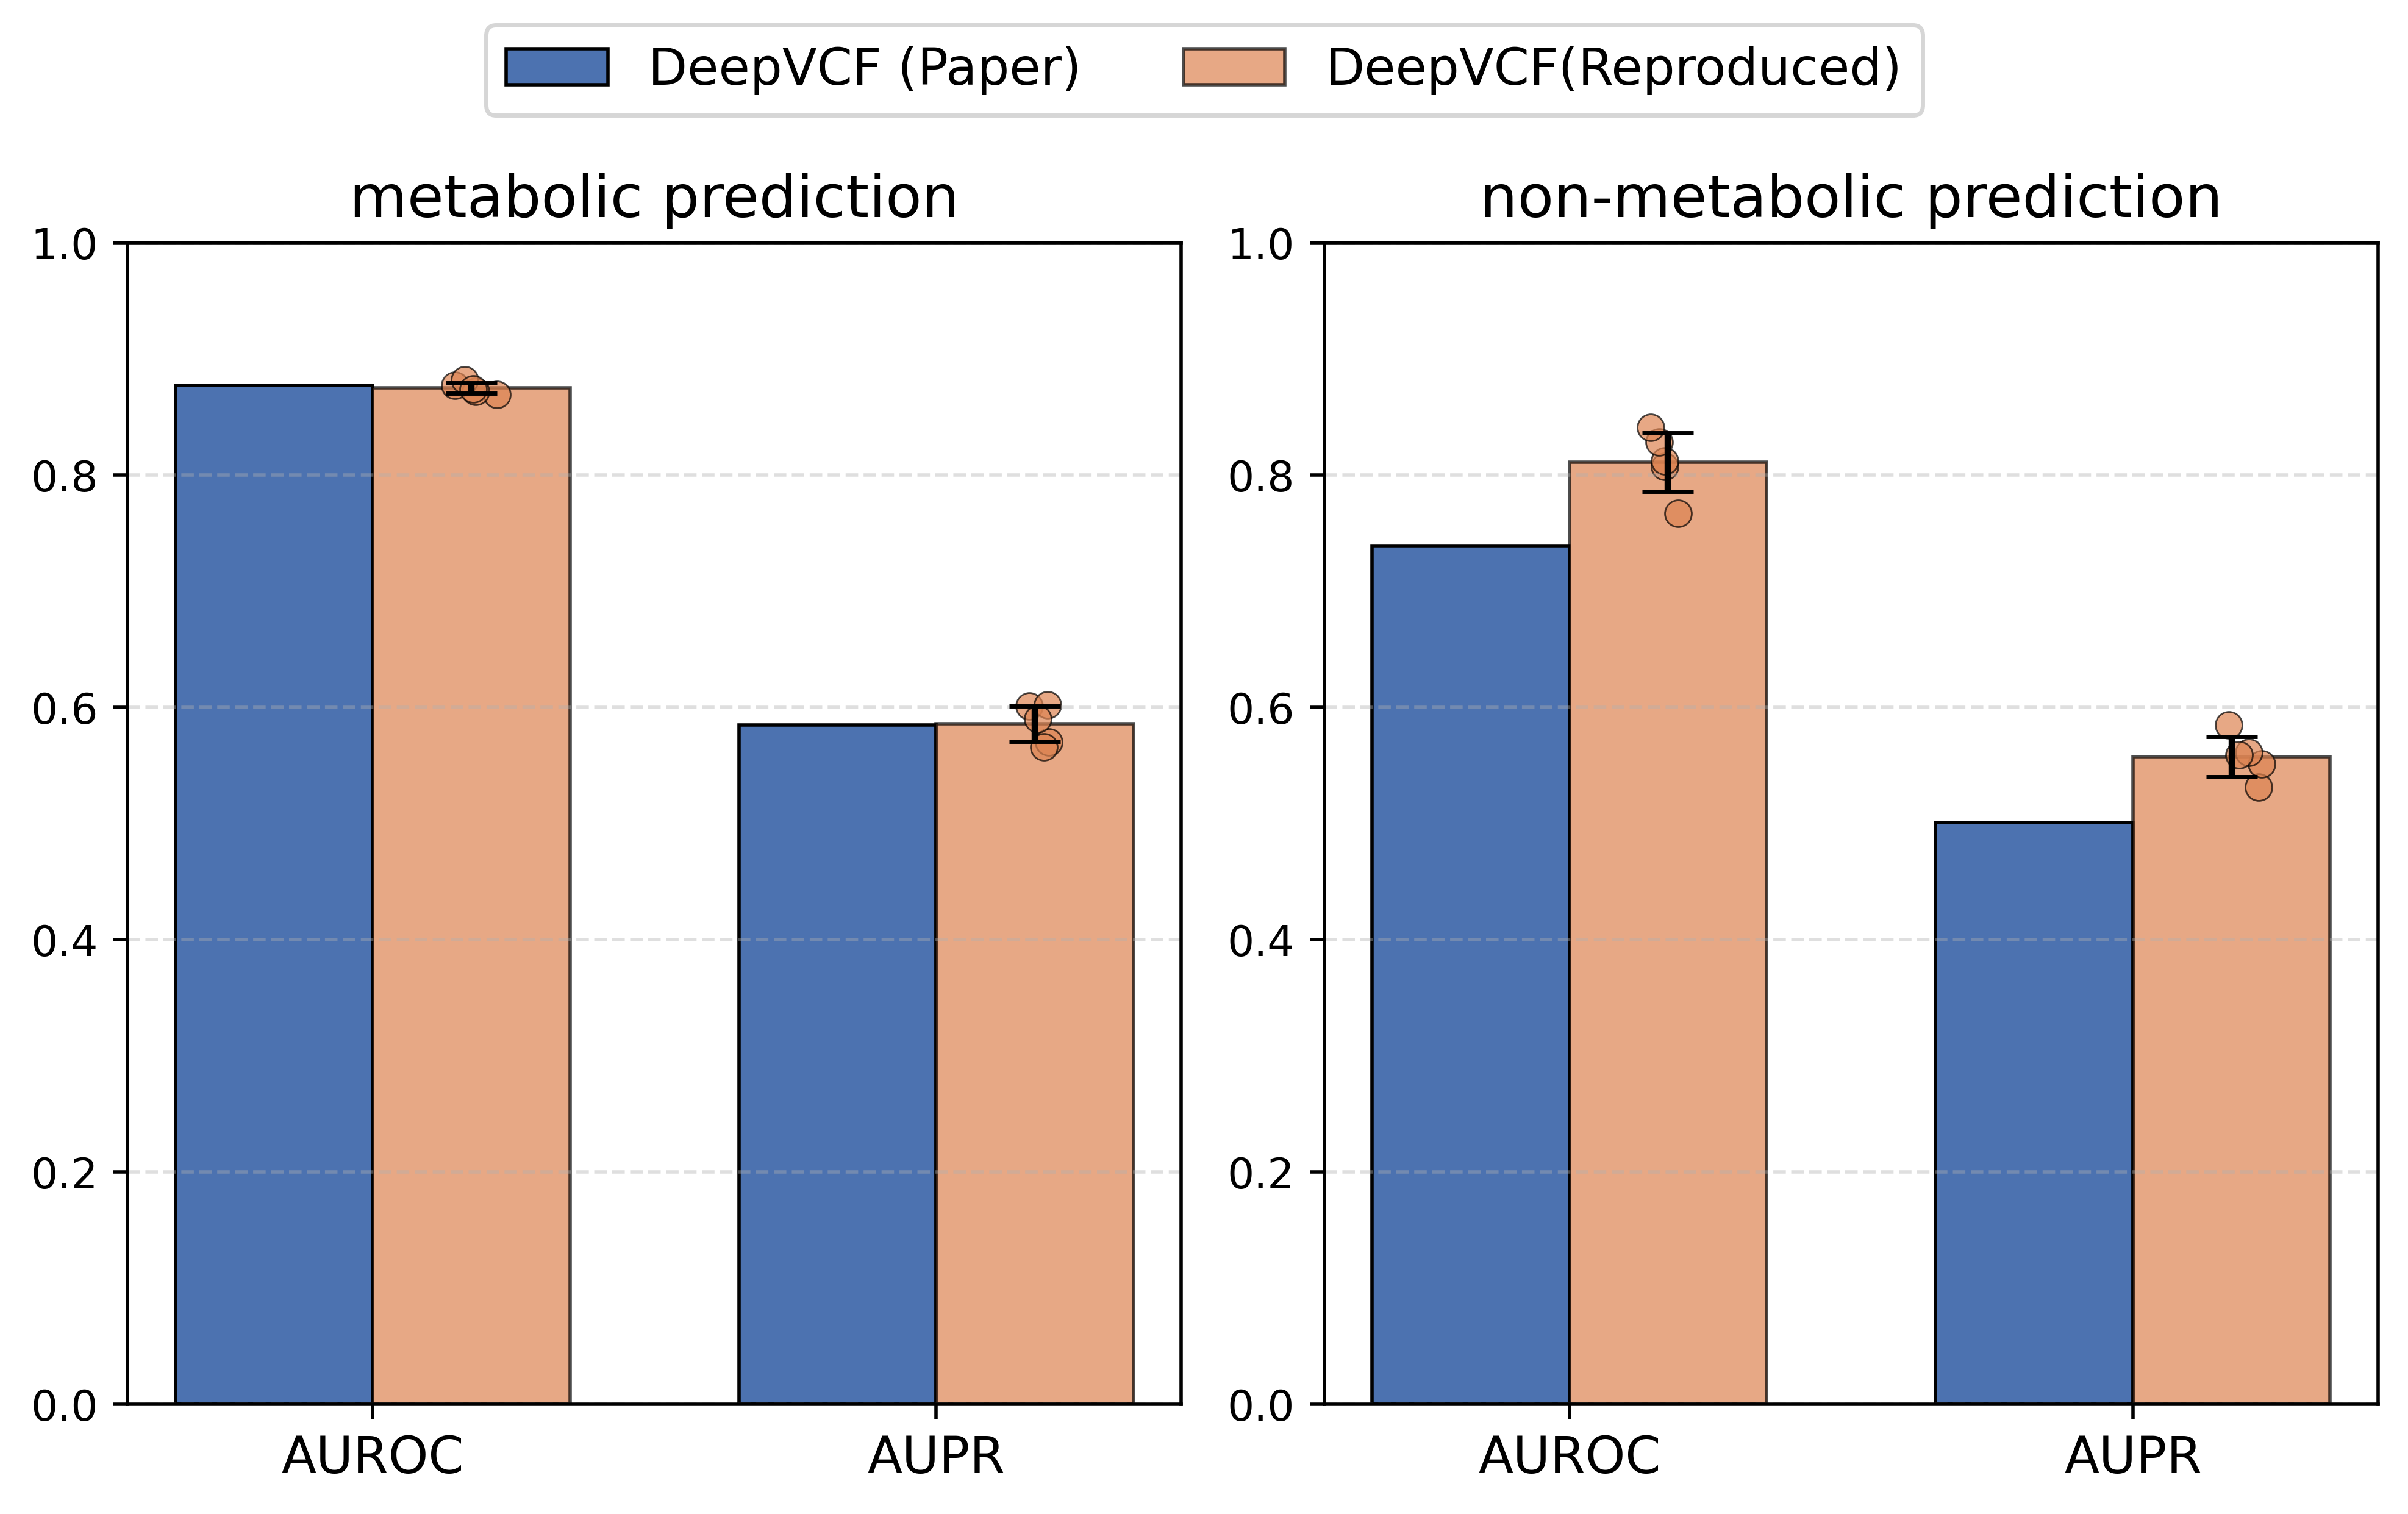

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# summary
# -----------------------------
tasks = ["metabolic", "non-metabolic"]

paper_AUROC = {"metabolic": 0.877, "non-metabolic": 0.739}
paper_AUPR  = {"metabolic": 0.585, "non-metabolic": 0.501}

repr_AUROC = {
    "metabolic": [0.877, 0.869, 0.872, 0.882, 0.874],
    "non-metabolic": [0.767, 0.807, 0.812, 0.828, 0.841]
}
repr_AUPR = {
    "metabolic": [0.601, 0.570, 0.566, 0.602, 0.590],
    "non-metabolic": [0.531, 0.551, 0.561, 0.585, 0.559]
}

# -----------------------------
# 配色 & 参数
# -----------------------------
paper_color = "#4C72B0"      # Blue
repr_color = "#DD8452"       # Orange
repr_alpha = 0.7

bar_width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(8, 5), dpi=500,sharey=False)

for i, task in enumerate(tasks):
    ax = axes[i]
    
    # positions
    x = np.array([0, 1])   # AUROC, AUPR
    x_paper = x - bar_width/2
    x_repr  = x + bar_width/2

    # means
    auroc_mean = np.mean(repr_AUROC[task])
    auroc_std  = np.std(repr_AUROC[task])
    aupr_mean  = np.mean(repr_AUPR[task])
    aupr_std   = np.std(repr_AUPR[task])

    # -----------------------------
    # 画 paper 和 reproduced 柱状图
    # -----------------------------
    # paper bars
    ax.bar(x_paper, 
           [paper_AUROC[task], paper_AUPR[task]],
           width=bar_width,
           color=paper_color,
           label="DeepVCF (Paper)" if i==0 else "",
           edgecolor="black",
           linewidth=0.8)

    # reproduced bars (mean + std)
    ax.bar(x_repr,
           [auroc_mean, aupr_mean],
           width=bar_width,
           yerr=[auroc_std, aupr_std],
           capsize=6,
           color=repr_color,
           alpha=repr_alpha,
           label="DeepVCF(Reproduced)" if i==0 else "",
           edgecolor="black",
           linewidth=0.8)

    # -----------------------------
    # 散点：每次复现
    # -----------------------------
    jitter = 0.03
    ax.scatter(np.random.normal(x_repr[0], jitter, len(repr_AUROC[task])),
               repr_AUROC[task],
               color=repr_color, alpha=0.7, s=40, edgecolor="black", linewidth=0.4)

    ax.scatter(np.random.normal(x_repr[1], jitter, len(repr_AUPR[task])),
               repr_AUPR[task],
               color=repr_color, alpha=0.7, s=40, edgecolor="black", linewidth=0.4)

    # axis formatting
    ax.set_xticks(x)
    ax.set_xticklabels(["AUROC", "AUPR"], fontsize=12)
    ax.set_title(f"{task} prediction", fontsize=14)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.set_ylim(0, 1)

# overall legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", fontsize=12, ncol=2)

plt.tight_layout(rect=[0,0,1,0.92])
plt.show()


## Using DeepVCF for real-world genome-scale target prediction

In [ ]:
# define query metabolite, gene prefix, 
query_met = ['Metabolite:hdca_c']
query_gene_prefix = 'ECO_Protein'
gene_type = 'whole genome' # 'whole genome' or 'metabolic gene' or 'non-metabolic gene'
output_dic = './'


In [ ]:
model.genome_scale_prediction(query_met, query_gene_prefix, gene_type, entity2idx, relation2idx, output_dic)